In [2]:
import pandas as pd

df = pd.concat([
    pd.read_csv('part1of3.csv.gz', compression='gzip'),
    pd.read_csv('part2of3.csv.gz', compression='gzip'),
    pd.read_csv('part3of3.csv.gz', compression='gzip')
])

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

lululemon = df[df["parent_merchant"] == "Lululemon (LULU)"]
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(lululemon.columns)

Index(['date', 'transaction_id', 'individual_id', 'channel', 'parent_merchant',
       'merchant', 'state', 'transaction_amount'],
      dtype='object')


# Cumulative statistics

In [4]:
print("Total Sales: " + str(lululemon["transaction_amount"].sum()))
print("Sales by sector: ")
sales = lululemon.groupby(by="merchant").agg(Total=("transaction_amount", "sum")).reset_index()
txns = lululemon.groupby(by="merchant").agg(Count=("transaction_id", "count")).reset_index()
print(sales)
print(txns)

Total Sales: 143864626.19
Sales by sector: 
             merchant         Total
0              Ivivva    363372.060
1           Lululemon 140743975.110
2  Lululemon Like New    101462.050
3              Mirror   2655816.970
             merchant    Count
0              Ivivva     3545
1           Lululemon  1197851
2  Lululemon Like New      801
3              Mirror    35313


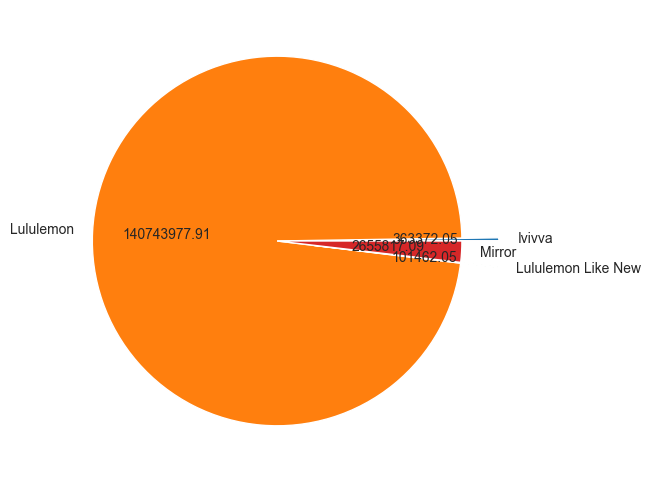

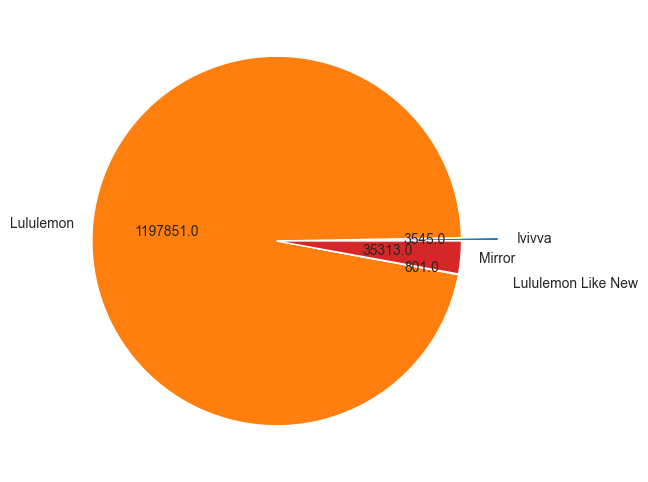

In [5]:
import numpy

def absolute_value(val):
    a  = numpy.round(val/100. * lululemon["transaction_amount"].sum(), 2)
    return a

def absolute_value1(val):
    a  = numpy.round(val/100. * lululemon["transaction_id"].count(), 0)
    return a

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
explode = [0.2, 0, 0.2, 0]
plt.pie(sales["Total"], labels=sales["merchant"], explode=explode, autopct=absolute_value)
plt.savefig("merchant_pie_chart.png", transparent=True)
plt.show()


plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
explode = [0.2, 0, 0.2, 0]
plt.pie(txns["Count"], labels=sales["merchant"], explode=explode, autopct=absolute_value1)
plt.savefig("merchant_txns_pie_chart.png", transparent=True)
plt.show()

Total: 208858


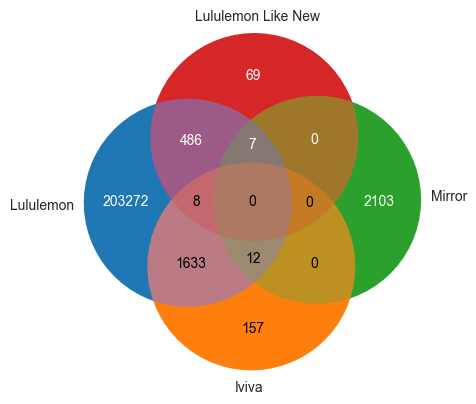

In [6]:
from matplotlib_set_diagrams import EulerDiagram, VennDiagram

lululemon_customers = set(lululemon[lululemon["merchant"] == "Lululemon"]["individual_id"].unique().tolist())
iviva_customers = set(lululemon[lululemon["merchant"] == "Ivivva"]["individual_id"].unique().tolist())
mirror_customers = set(lululemon[lululemon["merchant"] == "Mirror"]["individual_id"].unique().tolist())
lln_customers = set(lululemon[lululemon["merchant"] == "Lululemon Like New"]["individual_id"].unique().tolist())

VennDiagram.from_sets([
    lululemon_customers,
    iviva_customers,
    mirror_customers,
    lln_customers
], set_labels=["Lululemon", "Iviva", "Mirror", "Lululemon Like New"])

print("Total: " +  str(len(lululemon["individual_id"].unique().tolist())))

plt.savefig("merchant_customers_venn.png", transparent=True)

/Users/parth/Desktop/Select Equity Group Interview/venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/parth/Desktop/Select Equity Group Interview/venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

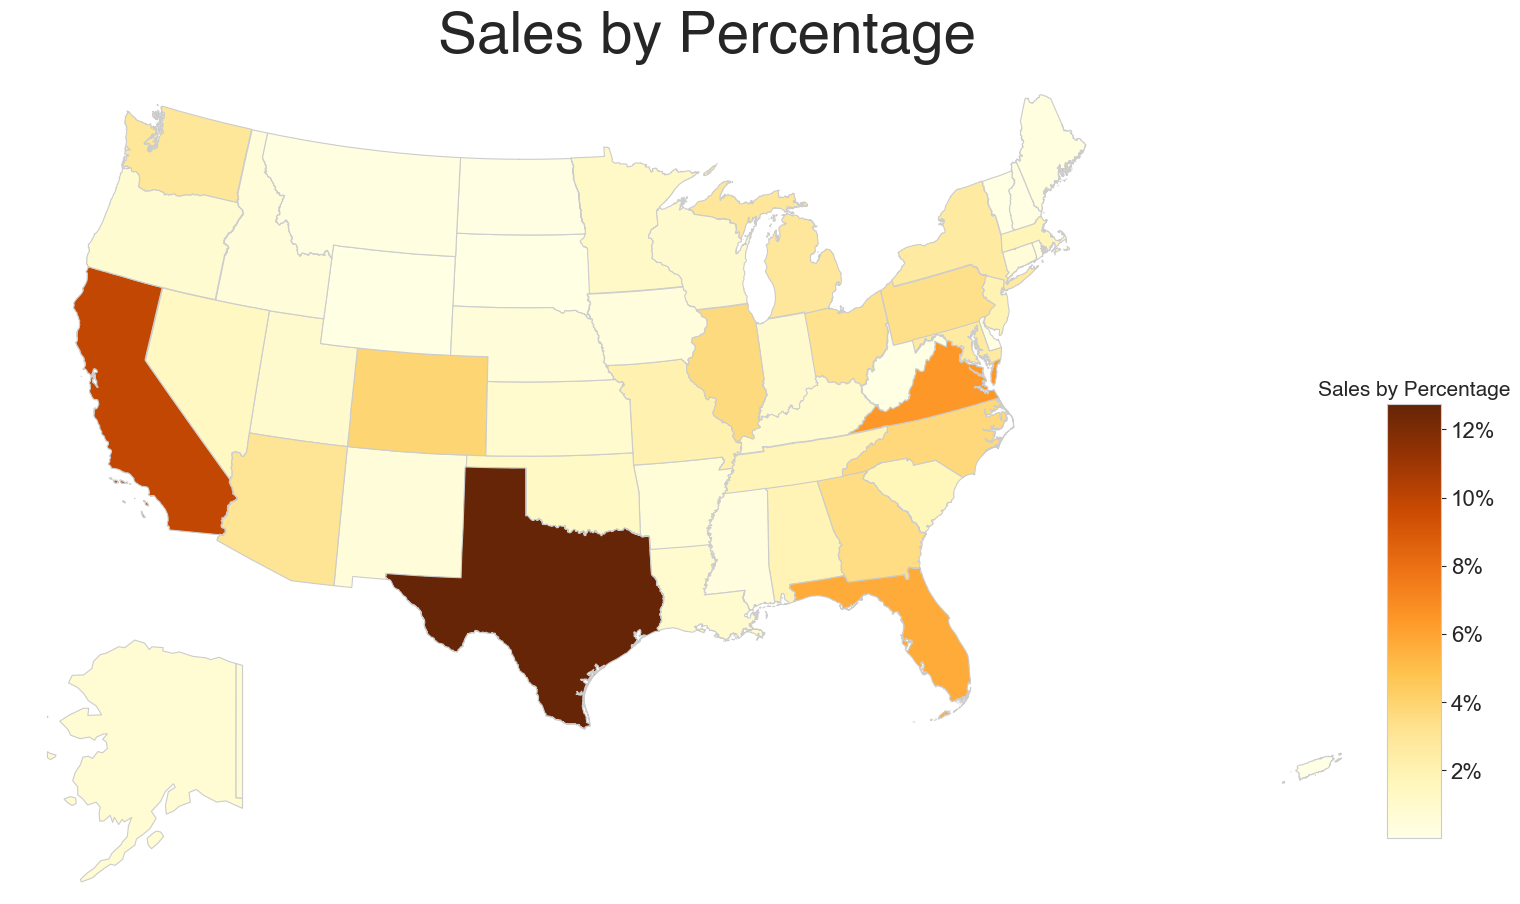

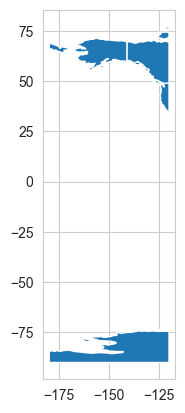

In [56]:
import wget
import geopandas as gpd
from shapely.geometry import Polygon
import shapely
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

sales_by_state = lululemon.groupby(by="state").agg(Percent=("transaction_amount", "sum")).reset_index()
sales_by_state["Percent"] = sales_by_state["Percent"] / lululemon["transaction_amount"].sum() * 100
gdf = gpd.read_file("./cb_2023_us_state_500k")
gdf = gdf.merge(sales_by_state,left_on='NAME',right_on='state')

world = gpd.read_file("./ne_110m_admin_0_countries")
polygon = Polygon([(-175,50),(-175,72),(-140, 72),(-140,50)])

alaska_gdf = world.clip(polygon)
# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})
# create map of all states except AK and HI in the main map axis
visframe[~visframe.STUSPS.isin(['HI','AK'])]

def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

variable = 'Percent'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.Percent.min(), gdf.Percent.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Sales by Percentage', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Sales by Percentage', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.STUSPS not in ['AK','HI']:
        vf = visframe[visframe.STUSPS==row.STUSPS]
        c = gdf[gdf.STUSPS==row.STUSPS][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
world.clip(polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color.item(), linewidth=0.8,ax=akax, edgecolor='0.8')


# # add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-200,-100),(-200,90),(-120,90),(-120,-100)])
print(hawaii_gdf = gdf[gdf.STUSPS=='HI'].value_determined_color.item())
world.clip(hipolygon).plot()


